# feature선택

* timeseries n_split의 default값은 5이지만 4로 나눴을 때 성능이 더 좋음.
* 명절 유무 변수를 추가하면 성능이 높아짐
* MACD 변수를 추가하면 성능이 낮아짐.
* pig관련 파생 변수를 추가로 생성하였을 때 성능이 더 낮아짐.

In [296]:
import pandas as pd
import os
import numpy as np
import warnings

from sklearn import preprocessing
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, ElasticNet

import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_squared_error, mean_absolute_error

os.chdir(r'C:\Users\a0105\Desktop\DSC\ddd\preprocessing')

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

### 데이터 불러오기 

In [334]:
data = pd.read_pickle('total.pkl')

In [335]:
data

,주간날짜,cow_resid_ma,cow_resid_diff,breed_cow_sd,no_breed_cow_sd,index,미국소_생산량(가격화한값),"번식우 아닌 소 중 1세 미만(암,수) 제외",1~2세(모든 소),한우 평균경매 금액_주간평균,...,번식우,번식우_no,resid,pig_resid,y_sd,y_before,pig_resid_before,전후2일_5일이동평균,pig_2_5_ma,y_diff
0,2013-01-13,1.001153,0.0,12.851852,-58.148148,1,226130.0,520,888,13213.33,...,1580,916,1.001153,1.001153,4.44089e-16,1.00115,1.00115,NaN,NaN,
1,2013-01-20,1.001153,0.0,12.851852,-58.148148,2,226130.0,520,888,12588.83,...,1580,916,1.001153,1.001153,4.44089e-16,1.00115,1.00115,12865.352000,2951.060000,0
2,2013-01-27,1.001153,0.0,12.851852,-58.148148,3,226130.0,520,888,12323.83,...,1580,916,1.001153,1.001153,4.44089e-16,1.00115,1.00115,12592.282000,2763.900000,0
3,2013-02-03,1.001153,0.0,12.851852,-58.148148,4,187340.0,520,888,12325.17,...,1580,916,1.001153,1.001153,4.44089e-16,1.00115,1.00115,12341.176000,2748.700000,0
4,2013-02-10,1.001153,0.0,12.851852,-58.148148,5,187340.0,520,888,12510.25,...,1580,916,1.001153,1.001153,4.44089e-16,1.00115,1.00115,12162.910000,2757.700000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,2018-08-19,1.001153,0.0,190.851852,-70.148148,293,242960.0,486,887,16835.00,...,1758,904,1.001153,1.001153,4.44089e-16,1.00115,1.00115,17829.800000,5287.500000,0
293,2018-08-26,1.001153,0.0,190.851852,-70.148148,294,242960.0,486,887,17555.00,...,1758,904,1.001153,1.001153,4.44089e-16,1.00115,1.00115,17970.400000,5393.700000,0
294,2018-09-02,1.001153,0.0,190.851852,-70.148148,295,215750.0,486,887,18369.00,...,1758,904,1.001153,1.001153,4.44089e-16,1.00115,1.00115,18054.600000,5513.700000,0
295,2018-09-09,1.001153,0.0,190.851852,-70.148148,296,215750.0,486,887,18757.00,...,1758,904,1.001153,1.001153,4.44089e-16,1.00115,1.00115,18359.500000,5565.875000,0


In [342]:
def EMA(close, timeperiod):
    k = 2/(1+timeperiod)
    close = close.dropna()
    
    ema = pd.Series(index=close.index)
    ema[timeperiod-1] = close.iloc[0:timeperiod].sum()/timeperiod
    
    for i in range(timeperiod, len(close)):
        ema[i] = close[i]*k + ema[i-1]*(1-k)
    return ema

In [343]:
def MACD(df, short = 12, long = 26, sign = 9):
    df['MACD'] = df['한우 평균경매 금액_주간평균'].ewm(span=short, min_periods = short, adjust = False).mean()\
                    -df['한우 평균경매 금액_주간평균'].ewm(span=long, min_periods=long, adjust=False).mean()
    return df

In [344]:
data = MACD(data)

In [359]:
# 변수명 추출
data_names = data2.drop(['주간날짜','한우 평균경매 금액_주간평균','index','돼지 탕박 경매 금액_주간평균','pig_before','MACD'],axis=1).columns
data_names = [list(i) for i in data_names]
features = [''.join(i) for i in data_names]
features

ma_scaler = preprocessing.MaxAbsScaler()
np_scaled_data = ma_scaler.fit_transform(data2[features])
scaled_data = data2.copy()

scaled_data[features] = np_scaled_data

X = scaled_data[features]
y = scaled_data['한우 평균경매 금액_주간평균']


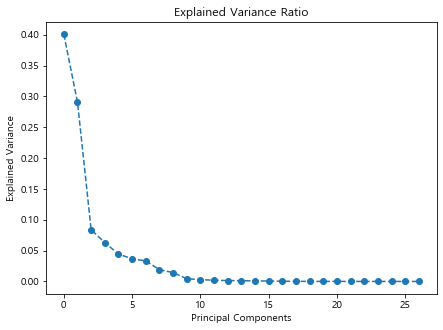

7

In [367]:
# 6개로 차원의 수를 줄임
pca = PCA(n_components=27)    # 함수 생성 
principalComponents = pca.fit(X).components_   #적용하여 component추출 

# 주성분 벡터가 이루는 축에 투영한 결과의 분산의 비율 = eignevalue 추출 
pca.explained_variance_ratio_
plt.figure(figsize=(7,5))
plt.plot(range(0,27), pca.explained_variance_ratio_, marker = 'o', linestyle = "--")
plt.ylabel('Explained Variance')
plt.xlabel('Principal Components')
plt.title('Explained Variance Ratio')
plt.show()

# 누적된 분산의 비율이 95%가 되는 주성분 축, 차원을 선택하여 차원 수 선택
d = np.argmax(np.cumsum(pca.explained_variance_ratio_)>=0.95)+1
d

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]


C:\Users\a0105\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


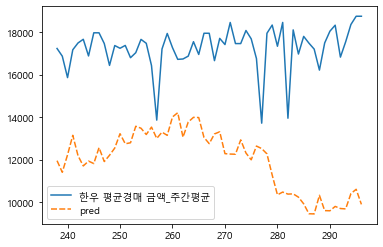

Root mean squared error:  2655.201510908211
mean absolute error:  47.82749106715891
-24.206547017757345
---
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118]


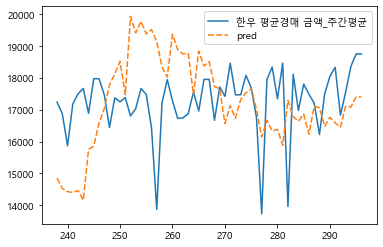

Root mean squared error:  1229.3186851061603
mean absolute error:  31.950129913938795
0.28419803217289424
---
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177]


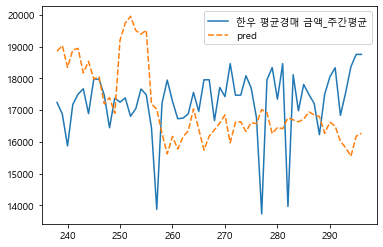

Root mean squared error:  458.2938889892808
mean absolute error:  19.38150952957365
0.8177877145315471
---
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 

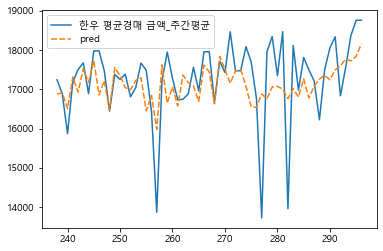

Root mean squared error:  877.5833432584648
mean absolute error:  24.723837881122087
0.22889963922689516
---


In [374]:
# 변수명 추출
data_naes = data2.drop(['주간날짜','한우 평균경매 금액_주간평균','index','돼지 탕박 경매 금액_주간평균','pig_before','MACD'],axis=1).columns
data_names = [list(i) for i in data_names]
features = [''.join(i) for i in data_names]
features

ma_scaler = preprocessing.MaxAbsScaler()
np_scaled_data = ma_scaler.fit_transform(data2[features])
scaled_data = data2.copy()

scaled_data[features] = np_scaled_data

pca = PCA(n_components=15)
    
X = pca.fit_transform(scaled_data[features])
y = scaled_data['한우 평균경매 금액_주간평균']

from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits = 4)

for train_index, test_index in tss.split(X):
    X_train, X_test = X[train_index, :], X[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    
    print(train_index)
    #test = pd.concat([X_test,y_test],axis=1)
    
    # regressor=MLPRegressor(hidden_layer_sizes=[128, 64, 32], max_iter=500, alpha=0.05, batch_size=10,random_state=7777)
    regressor=MLPRegressor(hidden_layer_sizes=[1024, 512, 32], max_iter=500, alpha=0.005, batch_size=10,random_state=7777)

    regressor.fit(X_train,y_train)

    pred = regressor.predict(X_test)
    pred

    test['pred'] = pred

    plt.figsize = (15,10)
    sns.lineplot(data = test[['한우 평균경매 금액_주간평균','pred']])
    plt.show()
    
    # 성능 
    mse = mean_squared_error(y_test, pred)
    mae = mean_absolute_error(y_test, pred)


    print('Root mean squared error: ', np.sqrt(mse))
    print('mean absolute error: ', np.sqrt(mae))
    print(regressor.score(X_test,y_test))
    print('---')


In [ ]:
ma_scaler = preprocessing.MaxAbsScaler()
np_scaled_data = ma_scaler.fit_transform(data2[features])
scaled_data = data2.copy()

scaled_data[features] = np_scaled_data

X = scaled_data[features]
y = scaled_data['한우 평균경매 금액_주간평균']

from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits = 4)

for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print(train_index)
    test = pd.concat([X_test,y_test],axis=1)
    
    # regressor=MLPRegressor(hidden_layer_sizes=[128, 64, 32], max_iter=500, alpha=0.05, batch_size=10,random_state=7777)
    regressor=MLPRegressor(hidden_layer_sizes=[1024, 518, 64], max_iter=500, alpha=0.005, batch_size=10,random_state=7777)

    regressor.fit(X_train,y_train)

    pred = regressor.predict(X_test)
    pred

    test['pred'] = pred

    plt.figsize = (15,10)
    sns.lineplot(data = test[['한우 평균경매 금액_주간평균','pred']])
    plt.show()
    
    # 성능 
    mse = mean_squared_error(y_test, pred)
    mae = mean_absolute_error(y_test, pred)


    print('Root mean squared error: ', np.sqrt(mse))
    print('mean absolute error: ', np.sqrt(mae))
    print('---')
    print(regressor.score(X_test,y_test))

### 모델 적용
- 개체 수 관련 변수를 제거하면 더욱 낮아짐

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]


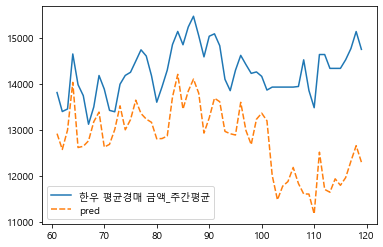

Root mean squared error:  1614.3771539461118
mean absolute error:  38.16617272889681
---
-8.318121944928285
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118]


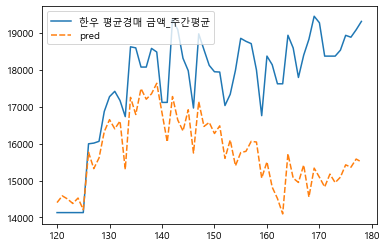

Root mean squared error:  2335.929608150981
mean absolute error:  44.434262565408154
---
-1.584540995957314
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177]


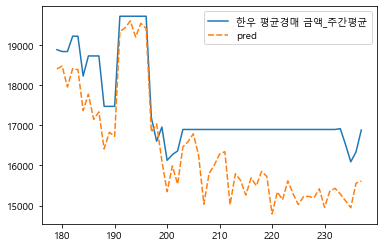

Root mean squared error:  1169.1061126660516
mean absolute error:  32.19683204238445
---
-0.18576160929787822
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 2

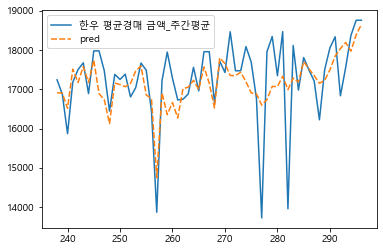

Root mean squared error:  799.4478008022476
mean absolute error:  23.395219311649647
---
0.36009664471681513


In [373]:
# 변수명 추출
data_names = data2.drop(['주간날짜','한우 평균경매 금액_주간평균','index','돼지 탕박 경매 금액_주간평균','pig_before','breed_cow_sd','no_breed_cow_sd'],axis=1).columns
data_names = [list(i) for i in data_names]
features = [''.join(i) for i in data_names]
features

ma_scaler = preprocessing.MaxAbsScaler()
np_scaled_data = ma_scaler.fit_transform(data2[features])
scaled_data = data2.copy()

scaled_data[features] = np_scaled_data

X = scaled_data[features]
y = scaled_data['한우 평균경매 금액_주간평균']

from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits = 4)

for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print(train_index)
    test = pd.concat([X_test,y_test],axis=1)
    
    # regressor=MLPRegressor(hidden_layer_sizes=[128, 64, 32], max_iter=500, alpha=0.05, batch_size=10,random_state=7777)
    regressor=MLPRegressor(hidden_layer_sizes=[1024, 518, 4], max_iter=500, alpha=0.005, batch_size=10,random_state=7777)

    regressor.fit(X_train,y_train)

    pred = regressor.predict(X_test)
    pred

    test['pred'] = pred

    plt.figsize = (15,10)
    sns.lineplot(data = test[['한우 평균경매 금액_주간평균','pred']])
    plt.show()
    
    # 성능 
    mse = mean_squared_error(y_test, pred)
    mae = mean_absolute_error(y_test, pred)


    print('Root mean squared error: ', np.sqrt(mse))
    print('mean absolute error: ', np.sqrt(mae))
    print(regressor.score(X_test,y_test))
    print('---')


In [ ]:
# 변수명 추출
data_names = data2.drop(['주간날짜','한우 평균경매 금액_주간평균','index','돼지 탕박 경매 금액_주간평균','pig_before'],axis=1).columns
data_names = [list(i) for i in data_names]
features = [''.join(i) for i in data_names]
features

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Root mean squared error:  918.8406888807026
mean absolute error:  28.056769759750853
---
-2.018553108587074
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118]
Root mean squared error:  3795.148677166831
mean absolute error:  57.736154499434235
---
-5.822153879719435
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  2

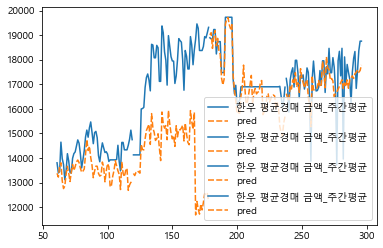

In [268]:
ma_scaler = preprocessing.MaxAbsScaler()
np_scaled_data = ma_scaler.fit_transform(data2[features])
scaled_data = data2.copy()

scaled_data[features] = np_scaled_data

X = scaled_data[features]
y = scaled_data['한우 평균경매 금액_주간평균']

from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits = 4)

for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print(train_index)
    test = pd.concat([X_test,y_test],axis=1)
    
    # regressor=MLPRegressor(hidden_layer_sizes=[128, 64, 32], max_iter=500, alpha=0.05, batch_size=10,random_state=7777)
    regressor=MLPRegressor(hidden_layer_sizes=[1024, 518, 64], max_iter=500, alpha=0.005, batch_size=10,random_state=7777)

    regressor.fit(X_train,y_train)

    pred = regressor.predict(X_test)
    pred

    test['pred'] = pred

    plt.figsize = (15,10)
    sns.lineplot(data = test[['한우 평균경매 금액_주간평균','pred']])
    plt.show()
    
    # 성능 
    mse = mean_squared_error(y_test, pred)
    mae = mean_absolute_error(y_test, pred)


    print('Root mean squared error: ', np.sqrt(mse))
    print('mean absolute error: ', np.sqrt(mae))
    print('---')
    print(regressor.score(X_test,y_test))

In [ ]:
# 변수명 추출
data_names = data2.drop(['주간날짜','한우 평균경매 금액_주간평균','index','돼지 탕박 경매 금액_주간평균','pig_before'],axis=1).columns
data_names = [list(i) for i in data_names]
features = [''.join(i) for i in data_names]
features

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Root mean squared error:  803.5247959638285
mean absolute error:  25.64105256076354
---
-1.3084312781401595
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118]
Root mean squared error:  3722.417161468783
mean absolute error:  57.01963596491555
---
-5.563175326117594
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28

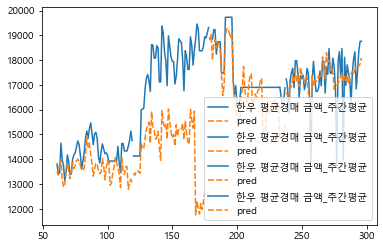

In [264]:
ma_scaler = preprocessing.MaxAbsScaler()
np_scaled_data = ma_scaler.fit_transform(data2[features])
scaled_data = data2.copy()

scaled_data[features] = np_scaled_data

X = scaled_data[features]
y = scaled_data['한우 평균경매 금액_주간평균']

from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits = 4)

for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print(train_index)
    test = pd.concat([X_test,y_test],axis=1)
    
    # regressor=MLPRegressor(hidden_layer_sizes=[128, 64, 32], max_iter=500, alpha=0.05, batch_size=10,random_state=7777)
    regressor=MLPRegressor(hidden_layer_sizes=[512, 218, 64], max_iter=500, alpha=0.005, batch_size=10,random_state=7777)

    regressor.fit(X_train,y_train)

    pred = regressor.predict(X_test)
    pred

    test['pred'] = pred

    plt.figsize = (15,10)
    sns.lineplot(data = test[['한우 평균경매 금액_주간평균','pred']])

    # 성능 
    mse = mean_squared_error(y_test, pred)
    mae = mean_absolute_error(y_test, pred)


    print('Root mean squared error: ', np.sqrt(mse))
    print('mean absolute error: ', np.sqrt(mae))
    print('---')
    print(regressor.score(X_test,y_test))

In [262]:
from sklearn.metrics import r2_score

ma_scaler = preprocessing.MaxAbsScaler()
np_scaled_data = ma_scaler.fit_transform(data2[features])
scaled_data = data2.copy()

scaled_data[features] = np_scaled_data

X = scaled_data[features]
y = scaled_data['한우 평균경매 금액_주간평균']

from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits = 4)

for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print(train_index)
    test = pd.concat([X_test,y_test],axis=1)
    
    # regressor=MLPRegressor(hidden_layer_sizes=[128, 64, 32], max_iter=500, alpha=0.05, batch_size=10,random_state=7777)

    models = [
        LinearRegression(), 
        MLPRegressor(hidden_layer_sizes=[512, 4], alpha=0.005, random_state=7777),
        MLPRegressor(hidden_layer_sizes=[48, 4], max_iter=5000, alpha=0.005, random_state=7777), 
        MLPRegressor(hidden_layer_sizes=[512, 4], max_iter=5000, alpha=0.005, random_state=7777), 
        MLPRegressor(hidden_layer_sizes=[1024, 4], max_iter=5000, alpha=0.005, random_state=7777),
        MLPRegressor(hidden_layer_sizes=[1024, 512, 4], max_iter=5000, alpha=0.005, random_state=7777),
    ]

    for m in models:
        m.fit(X_train, y_train)
        print(m.__class__)
        print(r2_score(y_train, m.predict(X_train)))
        print(r2_score(y_test, m.predict(X_test)))

    # 성능 
    mse = mean_squared_error(y_test, pred)
    mae = mean_absolute_error(y_test, pred)


    #print('Root mean squared error: ', np.sqrt(mse))
    #print('mean absolute error: ', np.sqrt(mae))
    #print('---')
    #print(regressor.score(X_test,y_test))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
<class 'sklearn.linear_model._base.LinearRegression'>
0.9493431429186621
-2.559610876217064e+21


C:\Users\a0105\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


<class 'sklearn.neural_network._multilayer_perceptron.MLPRegressor'>
-111.26495603607273
-581.3557861672132


C:\Users\a0105\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


<class 'sklearn.neural_network._multilayer_perceptron.MLPRegressor'>
0.7506770195822842
-3.4027071904855974


C:\Users\a0105\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


<class 'sklearn.neural_network._multilayer_perceptron.MLPRegressor'>
0.8254701133431053
-1.9984187784378342


C:\Users\a0105\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


<class 'sklearn.neural_network._multilayer_perceptron.MLPRegressor'>
-140.80962744981045
-727.0415397838914
<class 'sklearn.neural_network._multilayer_perceptron.MLPRegressor'>
-1.3698666009576916
-7.53131465048968


ValueError: Found input variables with inconsistent numbers of samples: [59, 49]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50]
Root mean squared error:  589.8868624410106
mean absolute error:  21.85865040468754
---
0.12106699585778868
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
Root mean squared error:  1947.3765400647885
mean absolute error:  39.54379659253897
---
-0.047262584611192704
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  

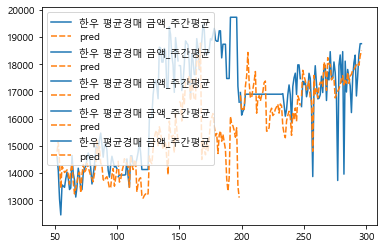

In [257]:
ma_scaler = preprocessing.MaxAbsScaler()
np_scaled_data = ma_scaler.fit_transform(data2[features])
scaled_data = data2.copy()

scaled_data[features] = np_scaled_data

X = scaled_data[features]
y = scaled_data['한우 평균경매 금액_주간평균']

from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits = 5)

for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print(train_index)
    test = pd.concat([X_test,y_test],axis=1)
    
    # regressor=MLPRegressor(hidden_layer_sizes=[128, 64, 32], max_iter=500, alpha=0.05, batch_size=10,random_state=7777)
    regressor=MLPRegressor(hidden_layer_sizes=[512, 218, 64], max_iter=500, alpha=0.05, batch_size=10,random_state=7777)

    regressor.fit(X_train,y_train)

    pred = regressor.predict(X_test)
    pred

    test['pred'] = pred

    plt.figsize = (15,10)
    sns.lineplot(data = test[['한우 평균경매 금액_주간평균','pred']])

    # 성능 
    mse = mean_squared_error(y_test, pred)
    mae = mean_absolute_error(y_test, pred)


    print('Root mean squared error: ', np.sqrt(mse))
    print('mean absolute error: ', np.sqrt(mae))
    print('---')
    print(regressor.score(X_test,y_test))

### pig_before 추가 전

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Root mean squared error:  878.6947498277676
mean absolute error:  27.2652942715147
---
-1.7605425576966143
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118]
Root mean squared error:  3723.972915473304
mean absolute error:  57.03549465268431
---
-5.568662524134184
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28 

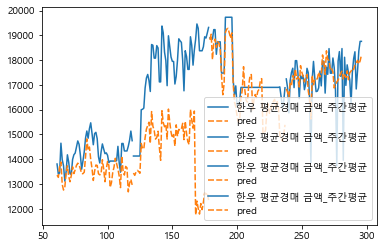

In [223]:
ma_scaler = preprocessing.MaxAbsScaler()
np_scaled_data = ma_scaler.fit_transform(data2[features])
scaled_data = data2.copy()

scaled_data[features] = np_scaled_data

X = scaled_data[features]
y = scaled_data['한우 평균경매 금액_주간평균']

from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits = 4)

for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print(train_index)
    test = pd.concat([X_test,y_test],axis=1)
    
    # regressor=MLPRegressor(hidden_layer_sizes=[128, 64, 32], max_iter=500, alpha=0.05, batch_size=10,random_state=7777)
    regressor=MLPRegressor(hidden_layer_sizes=[512, 218, 64], max_iter=500, alpha=0.05, batch_size=10,random_state=7777)

    regressor.fit(X_train,y_train)

    pred = regressor.predict(X_test)
    pred

    test['pred'] = pred

    plt.figsize = (15,10)
    sns.lineplot(data = test[['한우 평균경매 금액_주간평균','pred']])

    # 성능 
    mse = mean_squared_error(y_test, pred)
    mae = mean_absolute_error(y_test, pred)


    print('Root mean squared error: ', np.sqrt(mse))
    print('mean absolute error: ', np.sqrt(mae))
    print('---')
    print(regressor.score(X_test,y_test))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50]
Root mean squared error:  590.3100495505919
mean absolute error:  21.74867866022595
---
0.11980544364657618
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
Root mean squared error:  2427.6198643159064
mean absolute error:  45.50293293382848
---
-0.6274853401847278
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78

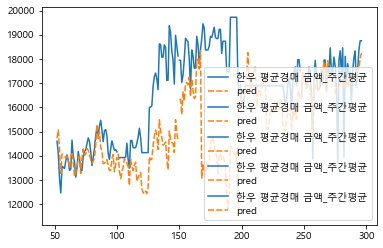

In [224]:
ma_scaler = preprocessing.MaxAbsScaler()
np_scaled_data = ma_scaler.fit_transform(data2[features])
scaled_data = data2.copy()

scaled_data[features] = np_scaled_data

X = scaled_data[features]
y = scaled_data['한우 평균경매 금액_주간평균']

from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits = 5)

for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print(train_index)
    test = pd.concat([X_test,y_test],axis=1)
    
    # regressor=MLPRegressor(hidden_layer_sizes=[128, 64, 32], max_iter=500, alpha=0.05, batch_size=10,random_state=7777)
    regressor=MLPRegressor(hidden_layer_sizes=[512, 218, 64], max_iter=500, alpha=0.05, batch_size=10,random_state=7777)

    regressor.fit(X_train,y_train)

    pred = regressor.predict(X_test)
    pred

    test['pred'] = pred

    plt.figsize = (15,10)
    sns.lineplot(data = test[['한우 평균경매 금액_주간평균','pred']])

    # 성능 
    mse = mean_squared_error(y_test, pred)
    mae = mean_absolute_error(y_test, pred)


    print('Root mean squared error: ', np.sqrt(mse))
    print('mean absolute error: ', np.sqrt(mae))
    print('---')
    print(regressor.score(X_test,y_test))

### 돼지탕박가격을 빼기 전

In [197]:
ma_scaler = preprocessing.MaxAbsScaler()
np_scaled_data = ma_scaler.fit_transform(data2[features])
scaled_data = data2.copy()

scaled_data[features] = np_scaled_data


In [198]:
split_date = '2017-07-30'

train = scaled_data[scaled_data['주간날짜'] <= split_date].copy()
test = scaled_data[scaled_data['주간날짜'] > split_date].copy()

Root mean squared error:  824.8893903024762
mean absolute error:  24.27164896511902
---
0.3187200646068237


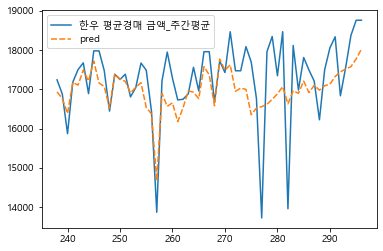

In [199]:
train_x = train[features]
train_y = train['한우 평균경매 금액_주간평균']

test_x = test[features]
test_y = test['한우 평균경매 금액_주간평균']

# regressor=MLPRegressor(hidden_layer_sizes=[128, 64, 32], max_iter=500, alpha=0.05, batch_size=10,random_state=7777)
regressor=MLPRegressor(hidden_layer_sizes=[512, 218, 64], max_iter=500, alpha=0.05, batch_size=10,random_state=7777)

regressor.fit(train_x,train_y)

pred = regressor.predict(test_x)
pred

test['pred'] = pred

plt.figsize = (15,10)
sns.lineplot(data = test[['한우 평균경매 금액_주간평균','pred']])

# 성능 
mse = mean_squared_error(test['한우 평균경매 금액_주간평균'], pred)
mae = mean_absolute_error(test['한우 평균경매 금액_주간평균'], pred)


print('Root mean squared error: ', np.sqrt(mse))
print('mean absolute error: ', np.sqrt(mae))
print('---')
print(regressor.score(test_x,test_y))

Root mean squared error:  914.5308192685069
mean absolute error:  25.24805855656288
---
0.2965077347322459


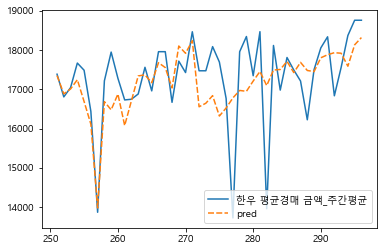

In [200]:
split_date = '2017-10-30'

train = scaled_data[scaled_data['주간날짜'] <= split_date].copy()
test = scaled_data[scaled_data['주간날짜'] > split_date].copy()


train_x = train[features]
train_y = train['한우 평균경매 금액_주간평균']

test_x = test[features]
test_y = test['한우 평균경매 금액_주간평균']

# regressor=MLPRegressor(hidden_layer_sizes=[128, 64, 32], max_iter=500, alpha=0.05, batch_size=10,random_state=7777)
regressor=MLPRegressor(hidden_layer_sizes=[512, 218, 64], max_iter=500, alpha=0.05, batch_size=10,random_state=7777)

regressor.fit(train_x,train_y)

pred = regressor.predict(test_x)
pred

test['pred'] = pred

plt.figsize = (15,10)
sns.lineplot(data = test[['한우 평균경매 금액_주간평균','pred']])

# 성능 
mse = mean_squared_error(test['한우 평균경매 금액_주간평균'], pred)
mae = mean_absolute_error(test['한우 평균경매 금액_주간평균'], pred)


print('Root mean squared error: ', np.sqrt(mse))
print('mean absolute error: ', np.sqrt(mae))
print('---')
print(regressor.score(test_x,test_y))

In [201]:
X = scaled_data[features]
X

,cow_resid_ma,cow_resid_diff,breed_cow_sd,no_breed_cow_sd,미국소_생산량(가격화한값),"번식우 아닌 소 중 1세 미만(암,수) 제외",1~2세(모든 소),돼지 탕박 경매 금액_주간평균,수출 (100만달러),수입 (100만달러),...,최소상대습도(%),평균상대습도(%),번식우,번식우_no,y_sd,y_before,pig_resid_before,전후2일_5일이동평균,y_diff,명절유무
1,0.935339,0.0,0.067339,-0.225510,0.930729,0.598389,0.928870,0.464194,0.925226,0.963348,...,0.481928,0.706972,0.898749,0.743506,3.120163e-15,0.909473,0.909473,0.652104,0.0,0.0
2,0.935339,0.0,0.067339,-0.225510,0.930729,0.598389,0.928870,0.473093,0.925226,0.963348,...,0.481928,0.686275,0.898749,0.743506,3.120163e-15,0.909473,0.909473,0.638263,0.0,1.0
3,0.935339,0.0,0.067339,-0.225510,0.771073,0.598389,0.928870,0.457613,0.925226,0.963348,...,0.265060,0.527233,0.898749,0.743506,3.120163e-15,0.909473,0.909473,0.625535,0.0,1.0
4,0.935339,0.0,0.067339,-0.225510,0.771073,0.598389,0.928870,0.337116,0.925226,0.963348,...,0.253012,0.406318,0.898749,0.743506,3.120163e-15,0.909473,0.909473,0.616499,0.0,0.0
5,0.935339,0.0,0.067339,-0.225510,0.771073,0.598389,0.928870,0.464834,0.925226,0.963348,...,0.228916,0.355120,0.898749,0.743506,3.120163e-15,0.909473,0.909473,0.611337,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,0.935339,0.0,1.000000,-0.272048,1.000000,0.559264,0.927824,0.847986,1.000000,1.000000,...,0.650602,0.788671,1.000000,0.733766,3.120163e-15,0.909473,0.909473,0.903736,0.0,0.0
293,0.935339,0.0,1.000000,-0.272048,1.000000,0.559264,0.927824,0.832401,1.000000,1.000000,...,0.650602,0.843137,1.000000,0.733766,3.120163e-15,0.909473,0.909473,0.910862,0.0,0.0
294,0.935339,0.0,1.000000,-0.272048,0.888006,0.559264,0.927824,0.886829,1.000000,1.000000,...,0.481928,0.654684,1.000000,0.733766,3.120163e-15,0.909473,0.909473,0.915130,0.0,0.0
295,0.935339,0.0,1.000000,-0.272048,0.888006,0.559264,0.927824,0.919757,1.000000,1.000000,...,0.746988,0.842048,1.000000,0.733766,3.120163e-15,0.909473,0.909473,0.930584,0.0,1.0


In [202]:
y = scaled_data['한우 평균경매 금액_주간평균']

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Root mean squared error:  802.6365472264009
mean absolute error:  25.791042103879754
---
-1.3033304328463315
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118]
Root mean squared error:  3628.438821679426
mean absolute error:  56.572103456797365
---
-5.235963037665208
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  

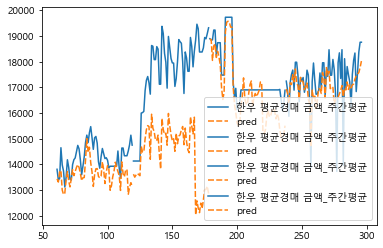

In [203]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits = 4)

for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print(train_index)
    test = pd.concat([X_test,y_test],axis=1)
    
    # regressor=MLPRegressor(hidden_layer_sizes=[128, 64, 32], max_iter=500, alpha=0.05, batch_size=10,random_state=7777)
    regressor=MLPRegressor(hidden_layer_sizes=[512, 218, 64], max_iter=500, alpha=0.05, batch_size=10,random_state=7777)

    regressor.fit(X_train,y_train)

    pred = regressor.predict(X_test)
    pred

    test['pred'] = pred

    plt.figsize = (15,10)
    sns.lineplot(data = test[['한우 평균경매 금액_주간평균','pred']])

    # 성능 
    mse = mean_squared_error(y_test, pred)
    mae = mean_absolute_error(y_test, pred)


    print('Root mean squared error: ', np.sqrt(mse))
    print('mean absolute error: ', np.sqrt(mae))
    print('---')
    print(regressor.score(X_test,y_test))

### 명절유무 포함하기 전

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Root mean squared error:  785.0922162719061
mean absolute error:  25.287838913981073
---
-1.2037368152945742
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118]
Root mean squared error:  3643.4797135368794
mean absolute error:  56.781411008589835
---
-5.287769807671011
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27 

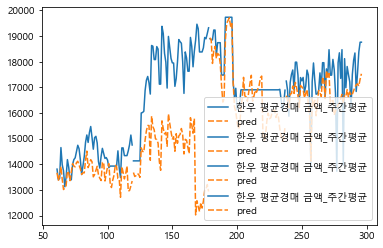

In [142]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits = 4)

for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print(train_index)
    test = pd.concat([X_test,y_test],axis=1)
    
    # regressor=MLPRegressor(hidden_layer_sizes=[128, 64, 32], max_iter=500, alpha=0.05, batch_size=10,random_state=7777)
    regressor=MLPRegressor(hidden_layer_sizes=[512, 218, 64], max_iter=500, alpha=0.05, batch_size=10,random_state=7777)

    regressor.fit(X_train,y_train)

    pred = regressor.predict(X_test)
    pred

    test['pred'] = pred

    plt.figsize = (15,10)
    sns.lineplot(data = test[['한우 평균경매 금액_주간평균','pred']])

    # 성능 
    mse = mean_squared_error(y_test, pred)
    mae = mean_absolute_error(y_test, pred)


    print('Root mean squared error: ', np.sqrt(mse))
    print('mean absolute error: ', np.sqrt(mae))
    print('---')
    print(regressor.score(X_test,y_test))

In [ ]:
X_train